<a href="https://colab.research.google.com/github/watanabe-gk/study_gpt/blob/main/%E4%BA%8B%E5%89%8D%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title モジュールのインストール
!pip install -qq datasets==2.18
!pip install -qq mecab-python3==1.0.8
!pip install -qq unidic-lite
!git clone https://github.com/Michi-123/whiteGPT.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.2.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Cloning into 'whiteGPT'...
remote: Enumerating objects: 1255, done.
remote: Counting objects: 100% (91/91), done.
remote: 

<h1><font color="cyan">None</font>の部分を書き換えていきましょう</h1>

In [2]:
#@title ライブラリーのインポート
import math
import torch
import torch.nn as nn
import torch.optim as optim # 最適化モジュール
from matplotlib import pyplot as plt # グラフの描画
import MeCab # 形態素解析

In [3]:
#@title Google Driveのマウント
# from google.colab import drive
# drive.mount('/content/drive')

GPUの使用を判定

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
#@title MeCabの利用 (日本語を形態素解析するプログラム)
tagger = MeCab.Tagger("-Owakati")

In [6]:
# @title Exercise
tagger.parse('私は昨日公園にいきました')

'私 は 昨日 公園 に いき まし た \n'

In [7]:
# @title 青空文庫データセットの利用
from datasets import load_dataset
ds = load_dataset('globis-university/aozorabunko-clean')
ds = ds.filter(lambda row: row['meta']['文字遣い種別'] == '新字新仮名')  # 新字新仮名に限定

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/16951 [00:00<?, ? examples/s]

In [8]:
authors = ['夏目'] #@param
# titles = [ 'こころ', '三四郎' ,'それから', '坊っちゃん']#@param
titles = ['文鳥', '正岡子規']#@param
corpus = ''
for book in ds['train']:
    title = book['meta']['作品名']
    author = book['meta']['姓']
    # if author in authors:
    if title in titles and author in authors:
        print(author, title)
        text = book['text'] # 本文
        text = ''.join(text.split()) # Clean up
        text = tagger.parse(text) # 形態素解析
        corpus += text

print(corpus[:100])

夏目 文鳥
夏目 正岡子規
十 月 早稲田 に 移る 。 伽藍 の よう な 書斎 に ただ 一人 、 片づけ た 顔 を 頬杖 で 支え て いる と 、 三重吉 が 来 て 、 鳥 を 御 飼い なさい と 云う 。 飼っ 


# Hyper parameter

In [9]:
# @markdown Model parameters

# 512 token GPT1
# 10
context_size = 10 # @param {type: "integer"}

# 768 GPT1 (512+256)
# 192
d_model = 64 #@param {type: "integer"}

# 12 GPT1
# 3
n_head = 2 #@param {type: "integer"}

# 12 layer in  GPT1
# 6
n_block = 3 #@param {type: "integer"}

# @markdown Train parameters
# 64 GPT1
# 64
batch_size = 64  #@param {type: "integer"}

# 2.5e-4
# 0.00025
leraning_rate = 0.00025  #@param {type: "number"}

# 100 GPT1
epoch_num = 150 #@param {type: "integer"}

# pre-trained.pkl
pre_trained_model_path = 'pre-trained.pkl' #@param {type: "string"}

In [10]:
# ハイパーパラメータの検証
if d_model % n_head != 0:
    print("埋め込みベクトルの次元はヘッドの数で割り切れる必要があります")
    raise ValueError("d_model must be divisible by n_head")

# インスタンス化

In [11]:
from whiteGPT import GPT, create_attention_mask # 完成コードの利用
from whiteGPT import DataLoader, Evaluate
from whiteGPT import JpTextDataset as Dataset

In [12]:
from random import shuffle
# Dataset と DataLoader
dataset = Dataset(corpus, context_size)
train_dataloader = DataLoader(dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [13]:
# マスク関数
mask = create_attention_mask(context_size).to(device)

In [14]:
# 評価モジュールの利用
evaluate = Evaluate(dataset, context_size)

In [15]:
# 語彙数の取得
vocab_size = len(dataset.vocab)
vocab_size

1596

In [16]:
# GPTモデルの作成とデバイス対応
model = GPT(vocab_size, context_size, d_model, n_head, n_block).to(device)

In [17]:
# クロスエントロピー誤差
criterion = nn.CrossEntropyLoss()
# 最適化モジュールの利用
optimizer = optim.Adam(model.parameters(), lr=leraning_rate)

In [18]:
is_load_model = False # @param{type:"boolean"}
if is_load_model:
    model.load_state_dict(torch.load(pre_trained_model_path, map_location=device))
    print('ok')

# 学習

In [19]:
#@title 初期化
start_epoch = 0
history = {"train_loss": []}
attn_list = [] # 潜在空間の可視化

epoch:1  index:148 loss:6.657182
source 愛想 を 尽かし た ん だろう と 、 この 時 
target 始め
output て

epoch:2  index:148 loss:5.483035
source くせ 寒い の で 鼻 の 頭 が 少し 紫色 
target に
output 。

epoch:3  index:148 loss:5.462783
source 高 さ は 木賊 より も ずっと 低い 。 庭 
target 下駄
output 。

epoch:4  index:148 loss:5.459215
source しまっ た 。 書物 を 縁側 へ 抛り出し て おい 
target て
output 。

epoch:5  index:148 loss:5.458068
source 飲む ところ を 見 た 。 細い 足 を 壺 
target の
output 。

epoch:6  index:148 loss:5.456532
source よく 見る と 足 が 一 本 しか ない 。 
target 自分
output 。



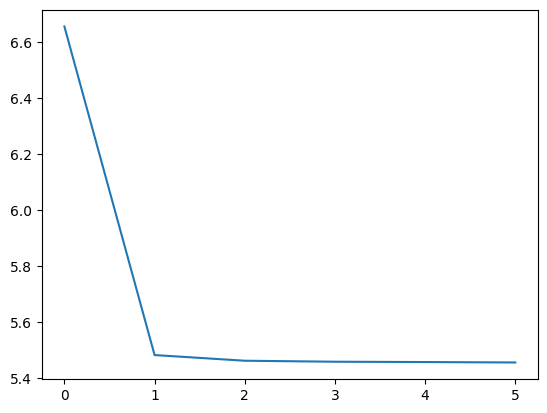

epoch:7  index:148 loss:5.455739
source い た 。 相 変ら ず 僕 は 何 も 
target 分ら
output 。

epoch:8  index:148 loss:5.455471
source やら なけれ ば なら ない 。 また 大きな 手 を 
target 籠
output 。

epoch:9  index:148 loss:5.454877
source は まだ ある 。 水 も まだ ある 。 文鳥 
target は
output 。

epoch:10  index:148 loss:5.451492
source と 万事 受合っ た 。 ところ へ 豊隆 が 袂 
target から
output 。

epoch:11  index:148 loss:5.430211
source から 引き出し て 、 握っ た 手 を 開ける と 
target 、
output に



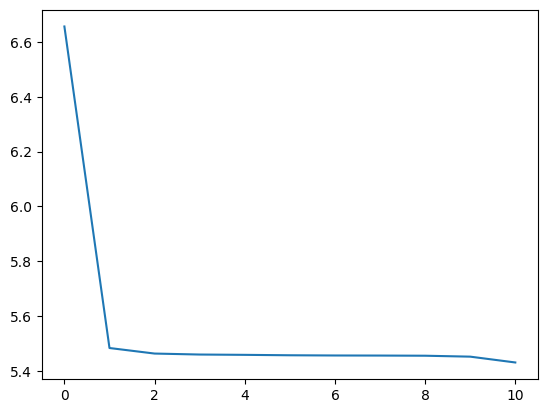

epoch:12  index:148 loss:5.347524
source 聞い て みる と 、 その ため に 箱 を 
target 作っ
output て

epoch:13  index:148 loss:5.216192
source へ は 誰 も 這入っ て 来 ない 習慣 で 
target あっ
output は

epoch:14  index:148 loss:5.062692
source 気 に 後 を 向い た 。 その 時 女 
target の
output の

epoch:15  index:148 loss:4.880519
source 非常 に 好き嫌い の あっ た 人 で 、 滅多 
target に
output に

epoch:16  index:148 loss:4.685410
source に 並べ た 。 その 一 本 を 軽く 踏まえ 
target た
output 。



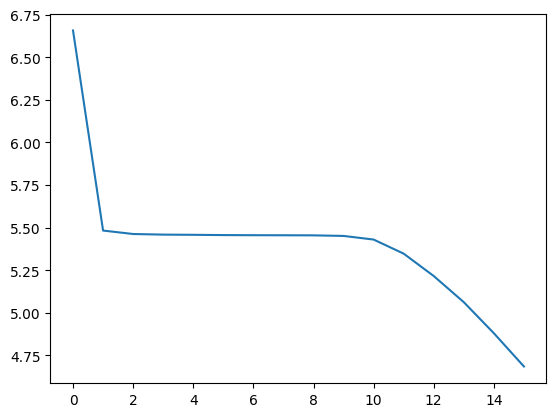

epoch:17  index:148 loss:4.494396
source 時分 は 、 一 軒 別棟 の 家 を 借り 
target て
output て

epoch:18  index:148 loss:4.322017
source あっ た 。 ところ が 出 て 見る と 粟 
target が
output の

epoch:19  index:148 loss:4.154806
source 。 彼 は 僕 など より 早熟 で 、 いや 
target に
output に

epoch:20  index:148 loss:4.010609
source と 云い だし た 。 これ も 宜しい と 答える 
target と
output た

epoch:21  index:148 loss:3.871681
source を ふかし て しまっ たら 、 起き て 籠 から 
target 出し
output 、



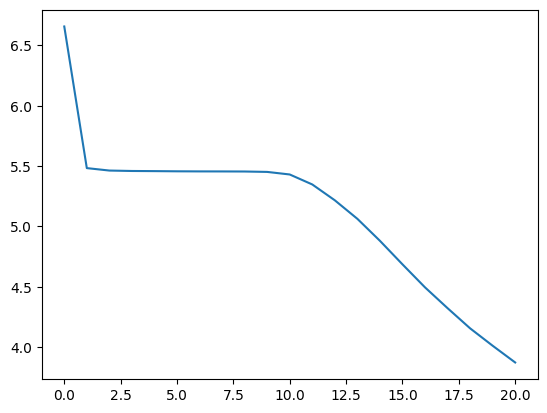

epoch:22  index:148 loss:3.731367
source 家人 が 悪い と も 残酷 だ と も いっこう 
target 書い
output に

epoch:23  index:148 loss:3.611121
source が あっ た が 、 詩 は 彼 の 方 
target が
output に

epoch:24  index:148 loss:3.475410
source で 立っ て いる 。 高 さ は 木賊 より 
target も
output よう

epoch:25  index:148 loss:3.358893
source 。 たいてい は 狭い 籠 を 苦 に も し 
target ない
output て

epoch:26  index:148 loss:3.258663
source た 。 尤も 厚い 独 逸書 で 、 外国 に 
target いる
output は



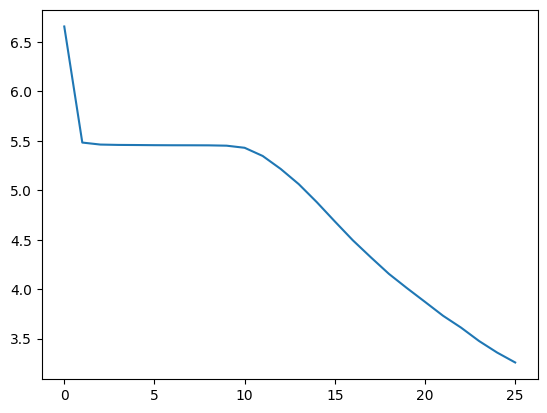

epoch:27  index:148 loss:3.130615
source 時 始め て 気 が つい た 。 する と 
target 三
output 、

epoch:28  index:148 loss:3.018611
source 霜 を 眺め て い た 。 自分 は とうとう 
target 机
output て

epoch:29  index:148 loss:2.922521
source た 。 晩 に は 箱 へ しまっ て やっ 
target た
output た

epoch:30  index:148 loss:2.823934
source を 洗っ て 、 食事 を 済まし て 、 始め 
target て
output た

epoch:31  index:148 loss:2.734738
source を し に 茶の間 へ 行っ た 。 その 頃 
target は
output に



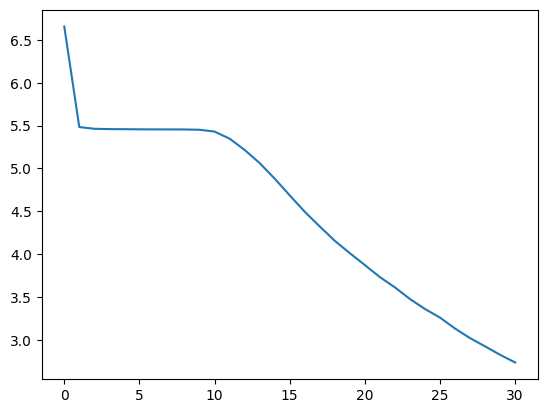

epoch:32  index:148 loss:2.640923
source に 並べ た 。 こう いっさい 万事 を 調え て 
target おい
output 、

epoch:33  index:148 loss:2.554660
source が ぽい と 留り 木 の 上 を 抜け出し た 
target 。
output 。

epoch:34  index:148 loss:2.492241
source で 方向 を 換え て い た 。 しきり に 
target 首
output 恰好

epoch:35  index:148 loss:2.413382
source も あろう 。 忘れ て い た が 、 彼 
target と
output の

epoch:36  index:148 loss:2.348302
source 文鳥 は 静 に 掌 の 上 に ある 。 
target 自分
output 文鳥



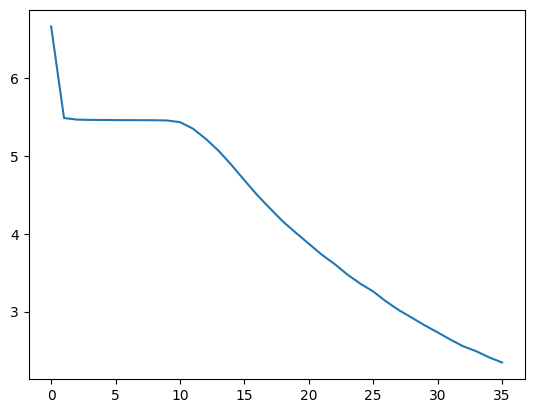

epoch:37  index:148 loss:2.284801
source 。 ） 又 彼 に は 政治 家 的 の 
target アム
output アム

epoch:38  index:148 loss:2.223319
source て 、 御 承知 の 通り ぴちゃぴちゃ と 音 を 
target さ
output 出

epoch:39  index:148 loss:2.167360
source し て い た の が 、 急 に 陽気 
target に
output に

epoch:40  index:148 loss:2.124061
source 暮し て い た 。 戸 は 二 重 に 
target 締め切っ
output 締め切っ

epoch:41  index:148 loss:2.071727
source 押し込ん だ の を 目撃 し た 。 かよう に 
target し
output 女



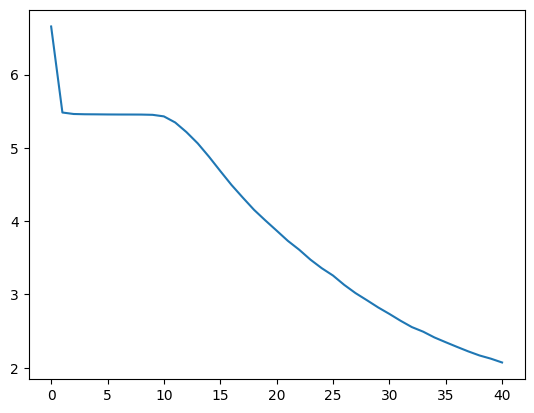

epoch:42  index:148 loss:2.027351
source ぬ か と 、 ちょっと 縁 へ 顔 だけ 出し 
target て
output て

epoch:43  index:148 loss:1.983946
source 件 を 思いだし た 。 いくら 当人 が 承知 だ 
target って
output と

epoch:44  index:148 loss:1.944307
source 八 の 字 に 寄っ て い た 。 それ 
target で
output から

epoch:45  index:148 loss:1.911026
source に 細い 淡紅 色 の 絹糸 を 縫いつけ た よう 
target な
output する

epoch:46  index:148 loss:1.877442
source 出し た 。 三重吉 は どこ で 買っ た か 
target 、
output で



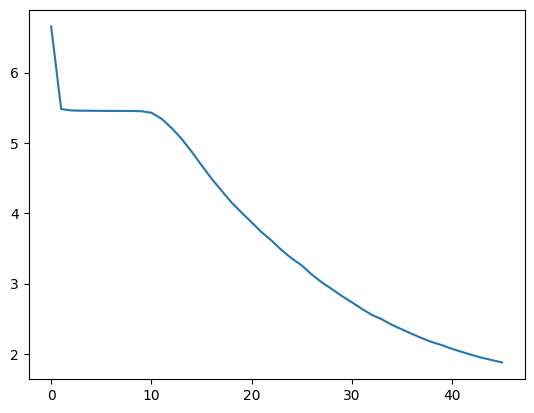

epoch:47  index:148 loss:1.840357
source 事 だけ は 抜い た と 見える 。 自分 が 
target 炭取
output 炭取

epoch:48  index:148 loss:1.806820
source 。 下女 は 、 どこ へ 持っ て 参り ます 
target か
output の

epoch:49  index:148 loss:1.771837
source など を 振り廻す もの だ から 、 僕 など は 
target 恐れ
output 恐れ

epoch:50  index:148 loss:1.734542
source て 行っ て 、 何 で も ない と いまいましい 
target から
output と

epoch:51  index:148 loss:1.717168
source の は この 初冬 の 晩 で あっ た 。 
target 三重吉
output 三重吉



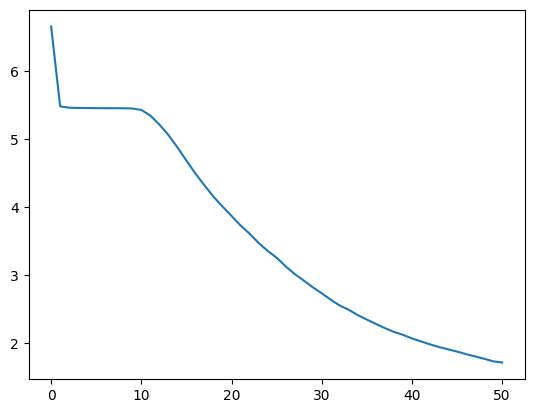

epoch:52  index:148 loss:1.682398
source 居る 。 僕 は 本 を 読む 事 も どう 
target する
output に

epoch:53  index:148 loss:1.657868
source 動い た 。 文鳥 の 足 は 向う の 留り 
target 木
output 木

epoch:54  index:148 loss:1.632155
source に 文鳥 の 体 が 薄白く 浮い た まま 留り 
target 木
output 木

epoch:55  index:148 loss:1.600991
source 縁側 へ 出 て 見 た 。 する と 文鳥 
target が
output が

epoch:56  index:148 loss:1.576371
source に 寄っ て い た 。 それ で 眼尻 と 
target 口元
output 口元



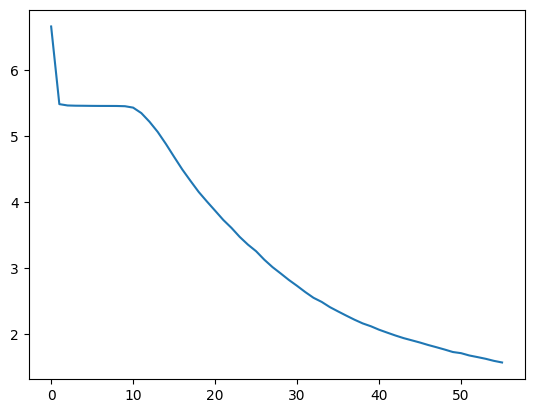

epoch:57  index:148 loss:1.554494
source 顔 が ちょっと 見え た 。 自分 は 床 の 
target 上
output 上

epoch:58  index:148 loss:1.522632
source を 見 て ことさら に 鳴く 気色 は さらに なかっ 
target た
output た

epoch:59  index:148 loss:1.504230
source に 入れる 癖 が ある 。 自分 は 三重吉 が 
target 五
output ある

epoch:60  index:148 loss:1.482988
source と 云っ て いる 。 なるほど 奇麗 だ 。 次の間 
target へ
output に

epoch:61  index:148 loss:1.444181
source が ある 男 と 思っ て い た 。 処 
target が
output に



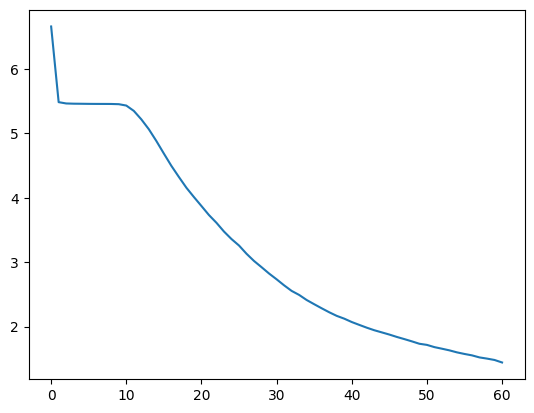

epoch:62  index:148 loss:1.430907
source 其 前 は 始終 僕 の 方 が 御 馳走 
target に
output に

epoch:63  index:148 loss:1.399046
source が さらさら する 。 書き かけ た 小説 は だいぶん 
target はかどっ
output はかどっ

epoch:64  index:148 loss:1.387212
source て 来 た 。 彼 は 僕 に は 大抵 
target な
output に

epoch:65  index:148 loss:1.365136
source 寝坊 だ から ちょうど 好い でしょう と 大変 文鳥 に 
target 親切
output 親切

epoch:66  index:148 loss:1.338216
source はずし て 、 文鳥 を 出し た 。 文鳥 は 
target 箱
output 箱



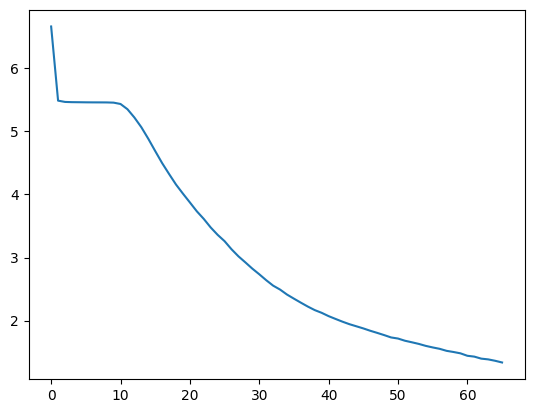

epoch:67  index:148 loss:1.312804
source を しばたたい て 、 心持 首 を すくめ て 、 
target 自分
output 自分

epoch:68  index:148 loss:1.303254
source は 抜け出し て いる 。 文鳥 は しのびやか に 鳥籠 
target の
output の

epoch:69  index:148 loss:1.284377
source 本 の 足 を 硬く 揃え て 、 胴 と 
target 直線
output 直線

epoch:70  index:148 loss:1.264819
source やがて 三重吉 は 鳥籠 を 叮嚀 に 箱 の 中 
target へ
output へ

epoch:71  index:148 loss:1.248325
source が 漆 で 塗っ て ある 。 竹 は 細く 
target 削っ
output 削っ



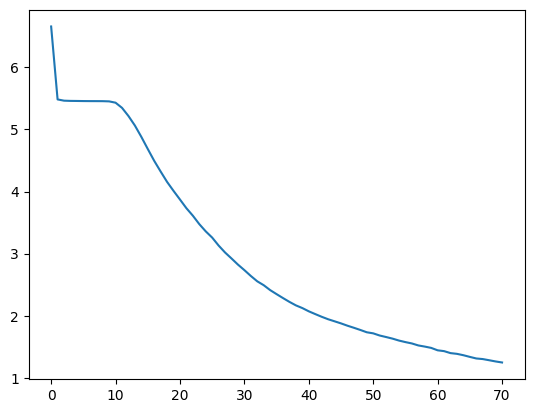

epoch:72  index:148 loss:1.222729
source と 僕 と 交際 し 始め た も 一 つ 
target の
output に

epoch:73  index:148 loss:1.202549
source 真白 な 胸 の 中 から 細い 足 を 一 
target 本
output 本

epoch:74  index:148 loss:1.195690
source 、 昨夕 叮嚀 に 餌 を やる 時 の 心得 
target を
output を

epoch:75  index:148 loss:1.175155
source 撮ん だ 顎 を 二 本 の 指 で 伸し 
target て
output た

epoch:76  index:148 loss:1.153310
source いる 二 本 の 留り 木 を 眺め た 。 
target そう
output そう



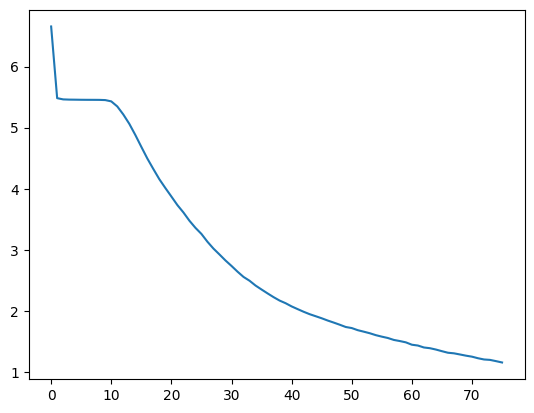

epoch:77  index:148 loss:1.137525
source は 動く 気色 も ない 。 音 を 立て ない 
target で
output ん

epoch:78  index:148 loss:1.119741
source ながら 、 左 の 手 を その 下 へ あてがっ 
target て
output て

epoch:79  index:148 loss:1.113844
source 文鳥 を 握っ て 見 た 。 柔かい 羽根 は 
target 冷
output 冷

epoch:80  index:148 loss:1.094427
source た 。 その 晩 寝 た の は 十 二 
target 時
output また

epoch:81  index:148 loss:1.070225
source に かから ない で は なかっ た が 、 やはり 
target ちょっと
output ちょっと



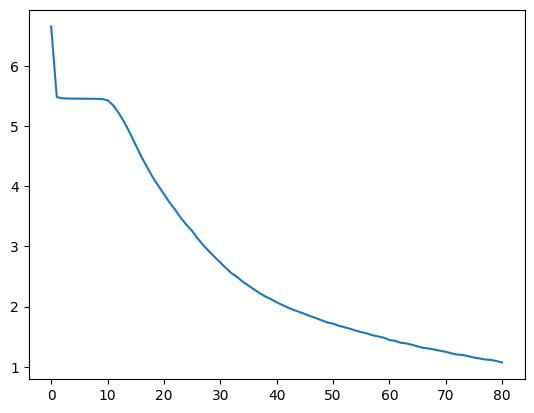

epoch:82  index:148 loss:1.073449
source も 無かっ た が 、 兎に角 自分 の 時間 と 
target いう
output やる

epoch:83  index:148 loss:1.054134
source な 寛大 な 事 を 云う 。 で も 君 
target あて
output あて

epoch:84  index:148 loss:1.036566
source 廻る のみ で あっ た 。 二三 度 試み た 
target 後
output が

epoch:85  index:148 loss:1.008374
source て い た 。 尤も 厚い 独 逸書 で 、 
target 外国
output 外国

epoch:86  index:148 loss:1.012430
source 上 へ 胸 から 上 を 翳し て 、 浮か 
target ぬ
output ぬ



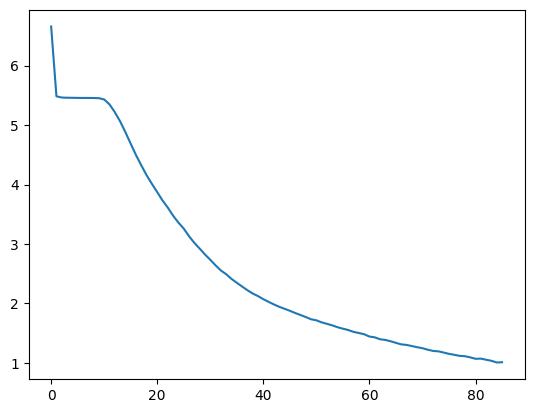

epoch:87  index:148 loss:1.001078
source 留り 木 は 抜け出し て いる 。 文鳥 は しのびやか 
target に
output に

epoch:88  index:148 loss:0.982064
source 要心 し て 入れ た に も かかわら ず 、 
target 文鳥
output 僕

epoch:89  index:148 loss:0.965416
source 水 も 全く 濁っ て しまっ た 。 書物 を 
target 縁側
output 戸

epoch:90  index:148 loss:0.958992
source と 云っ て 帰っ た 。 自分 は 伽藍 の 
target よう
output よう

epoch:91  index:148 loss:0.953699
source 自分 を 立てよう と し たら 迚も 円滑 な 交際 
target の
output を



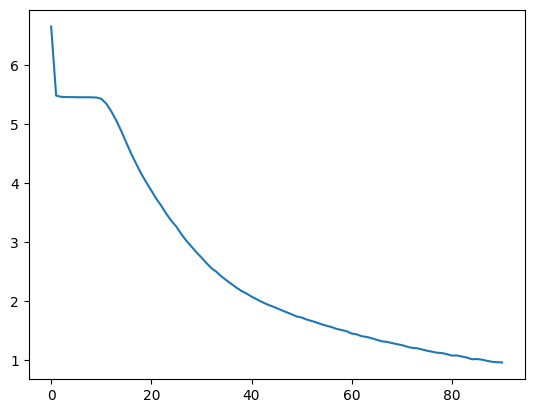

epoch:92  index:148 loss:0.932550
source た 。 今 は 残っ て い ない が 、 
target 孰れ
output 孰れ

epoch:93  index:148 loss:0.927096
source と し て 静か で ある 。 重い もの で 
target ある
output あっ

epoch:94  index:148 loss:0.911050
source する と 裏庭 で 、 子供 が 文鳥 を 埋る 
target ん
output ん

epoch:95  index:148 loss:0.912614
source た 。 三重吉 が 聞い たら さぞ 喜ぶ だろう と 
target 思う
output 思う

epoch:96  index:148 loss:0.881995
source まし た と ある ばかり で 家人 が 悪い と 
target も
output も



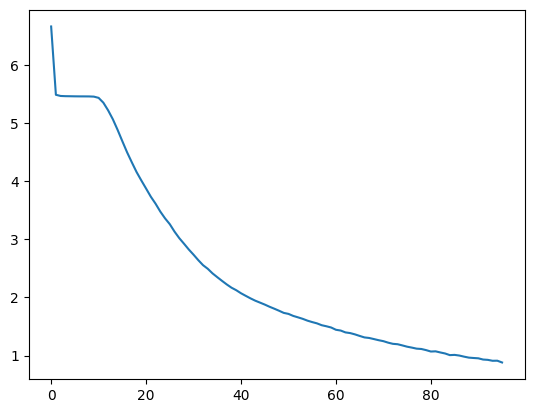

epoch:97  index:148 loss:0.873589
source も せ ぬ もの を 頻り に ひっくりかえし て い 
target た
output た

epoch:98  index:148 loss:0.862528
source に 、 自分 の 顔 を 見 て ことさら に 
target 鳴く
output 鳴く

epoch:99  index:148 loss:0.854868
source が 邪魔 に なっ て いか ぬ から 、 後ろ向き 
target に
output に

epoch:100  index:148 loss:0.835360
source 極めて 居る 。 御 承知 の 通り 僕 は 上野 
target の
output の

epoch:101  index:148 loss:0.828391
source 胴 と 直線 に 伸ばし て い た 。 自分 
target は
output は



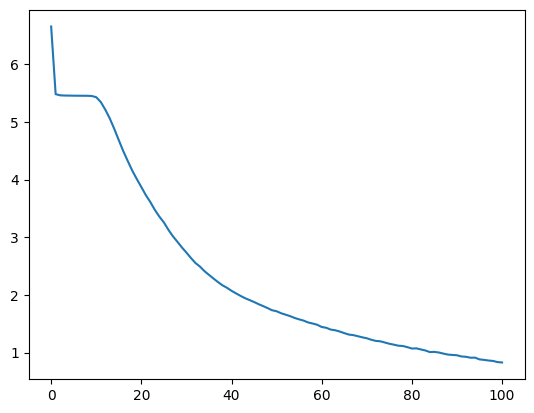

epoch:102  index:148 loss:0.817052
source 騒ぎ 廻る のみ で あっ た 。 二三 度 試み 
target た
output た

epoch:103  index:148 loss:0.799552
source て 、 縁側 へ 持ち出し て 、 ここ へ 置き 
target ます
output ます

epoch:104  index:148 loss:0.799642
source 男 で 、 僕 など も 一緒 に 矢張り 気位 
target の
output の

epoch:105  index:148 loss:0.780542
source 。 その 頃 は 日課 と し て 小説 を 
target 書い
output 書い

epoch:106  index:148 loss:0.782083
source もの が 、 どう か する だろう と 思っ た 
target 。
output 。



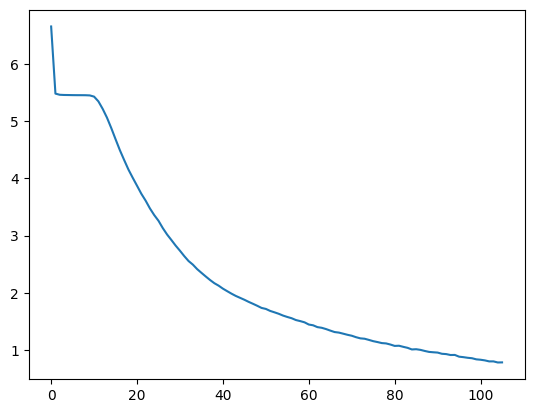

epoch:107  index:148 loss:0.760034
source に ペン の 音 を 聞い て いる と 、 
target 突然
output 突然

epoch:108  index:148 loss:0.755130
source 三 円 だ と 云う 。 安い なあ 豊隆 と 
target 云っ
output ね

epoch:109  index:148 loss:0.737144
source あっ た 。 筆 の 音 に 淋し さ と 
target 云う
output 遣っ

epoch:110  index:148 loss:0.733265
source 水 入 を 出し て 行儀 よく 自分 の 前 
target に
output に

epoch:111  index:148 loss:0.717493
source 伸し て 籠 の 外 を 下 の 方 から 
target 覗い
output 覗い



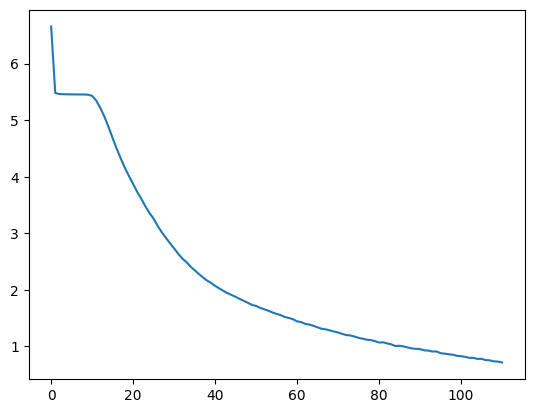

epoch:112  index:148 loss:0.707922
source て い た 。 あの 時分 から 正岡 に は 
target 何時
output 何時

epoch:113  index:148 loss:0.687046
source こと が あっ た 。 ある 晩 いつ も の 
target 通り
output 通り

epoch:114  index:148 loss:0.686462
source 。 しきり に 首 を 左右 に 傾ける 。 傾け 
target かけ
output かけ

epoch:115  index:148 loss:0.686633
source 文鳥 の 声 を 聞く だけ が 役目 の よう 
target に
output に

epoch:116  index:148 loss:0.665534
source な 留り 木 を 甘く 抱え込ん で いる 。 する 
target と
output と



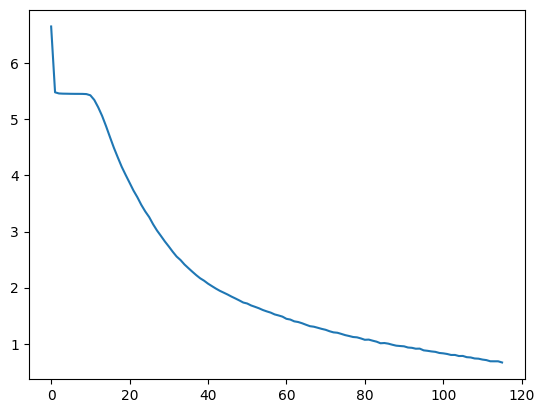

epoch:117  index:148 loss:0.666151
source 光る ほど 涸れ て いる 。 西 へ 廻っ た 
target 日
output 日

epoch:118  index:148 loss:0.642215
source を 取り寄せ て 、 御 承知 の 通り ぴちゃぴちゃ と 
target 音
output 音

epoch:119  index:148 loss:0.640929
source は 自分 の 方 を 向い た まま 、 留り 
target 木
output 木

epoch:120  index:148 loss:0.626214
source の 万松 庵 に 居る から すぐ 来い と いう 
target 。
output 。

epoch:121  index:148 loss:0.610702
source が いろいろ 長く なっ て 、 いっしょ に 午飯 を 
target 食う
output 食う



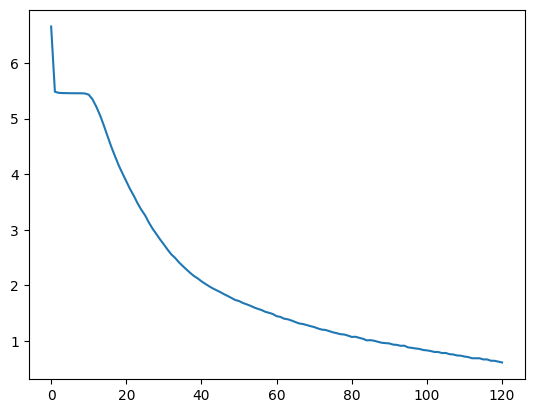

epoch:122  index:148 loss:0.603686
source 入れ て 置い た 、 それ を 見せ た 事 
target が
output を

epoch:123  index:148 loss:0.594362
source いる 。 その 様子 が なかなか 無邪気 で ある 。 
target 昔
output 昔

epoch:124  index:148 loss:0.596295
source から 、 文鳥 は とうとう 死ん で しまっ た 。 
target たのみ
output たのみ

epoch:125  index:148 loss:0.572248
source 実 の ある 粟 を 一々 拾い出さ なくっ ちゃ なり 
target ませ
output ませ

epoch:126  index:148 loss:0.570302
source 。 依然 と し て 急ぐ 小説 を 書い て 
target い
output い



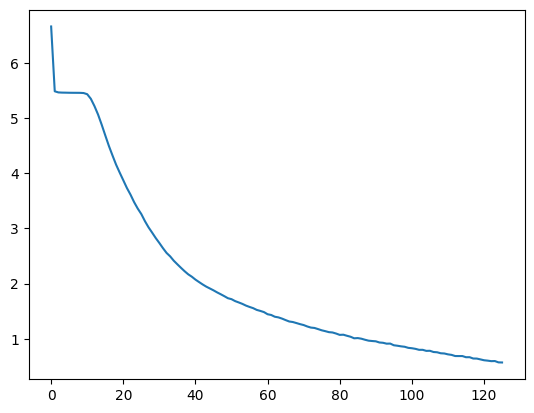

epoch:127  index:148 loss:0.576128
source 。 飛び込ん だ 時 は 尾 も 余り 、 頭 
target も
output が

epoch:128  index:148 loss:0.554310
source 音 を 立て て 侘びしい 事 を 書き連ね て いる 
target と
output と

epoch:129  index:148 loss:0.539560
source 八 の 字 に 寄っ て い た 。 それ 
target で
output で

epoch:130  index:148 loss:0.533368
source ほど 熟さ なかっ た 。 或 部分 は 万事 が 
target 弟
output 弟

epoch:131  index:148 loss:0.529086
source は 、 撮ん だ 顎 を 二 本 の 指 
target で
output に



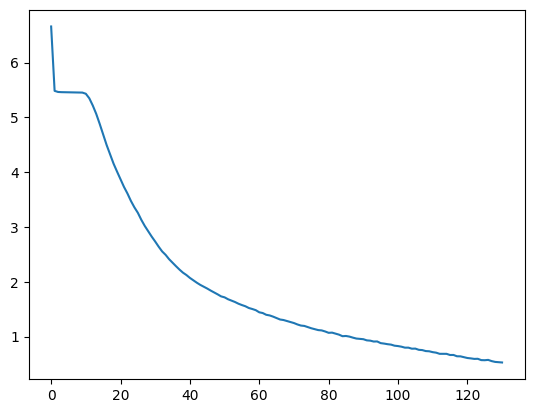

epoch:132  index:148 loss:0.513077
source なかっ た 僕 も 、 えらい もの の よう に 
target 思っ
output いう

epoch:133  index:148 loss:0.521873
source それ で 其 火鉢 で 牛肉 を じゃあじゃあ 煮 て 
target 食う
output 食う

epoch:134  index:148 loss:0.496716
source 余り 、 頭 も 余り 、 背 は 無論 余る 
target 。
output 。

epoch:135  index:148 loss:0.492834
source た 。 筆 を 擱い て 、 そっと 出 て 
target 見る
output 、

epoch:136  index:148 loss:0.475417
source 余り 、 頭 も 余り 、 背 は 無論 余る 
target 。
output 。



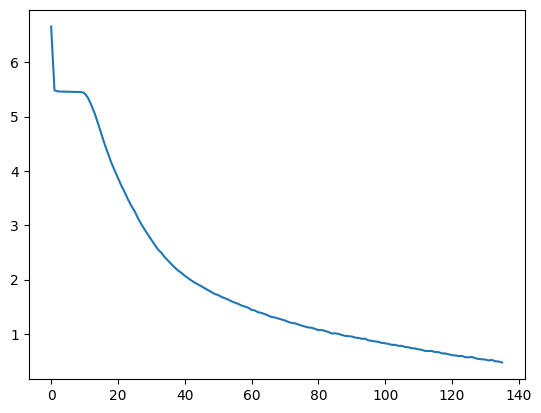

epoch:137  index:148 loss:0.482575
source 。 その 説 に よる と 、 むやみ に 籠 
target の
output の

epoch:138  index:148 loss:0.485345
source は 三重吉 の 小説 に 出 て 来る くらい だ 
target から
output から

epoch:139  index:148 loss:0.464436
source 出し た 。 自分 は 戸 を 閉 てて 火鉢 
target へ
output で

epoch:140  index:148 loss:0.462388
source なか へ 入れ て やっ た 。 翌日 文鳥 は 
target 例
output 例

epoch:141  index:148 loss:0.445152
source 金 を 貸せ と いう 。 何 で も 十 
target 円
output 円



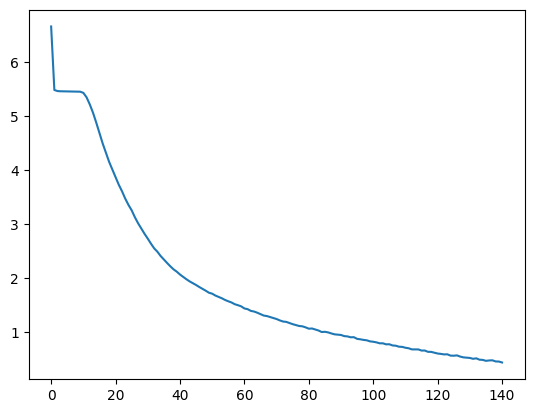

epoch:142  index:148 loss:0.436733
source 哲学 など を 振り廻す もの だ から 、 僕 など 
target は
output か

epoch:143  index:148 loss:0.442214
source 麭 の 粉 など を 人 指 指 の 先 
target へ
output へ

epoch:144  index:148 loss:0.429576
source に は 、 この 土手 登る べから ず と あっ 
target た
output た

epoch:145  index:148 loss:0.432659
source いる 。 その 様子 が なかなか 無邪気 で ある 。 
target 昔
output 昔

epoch:146  index:148 loss:0.416839
source も 定めし 鳴き 善かろう と 思う くらい で あっ た 
target 。
output 。



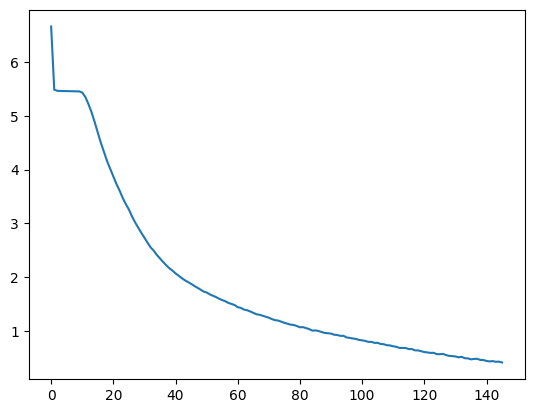

epoch:147  index:148 loss:0.412508
source 落ち た 。 しかし 鳥 と 籠 と は 容易 
target に
output に

epoch:148  index:148 loss:0.404696
source 風 か 何 か の 書体 を 書い て い 
target た
output た

epoch:149  index:148 loss:0.391433
source が あっ た が 、 詩 は 彼 の 方 
target が
output の

epoch:150  index:148 loss:0.392247
source し て この 竹 は 一 返 善く 煮 た 
target ん
output ん



In [20]:
#@title Train

# Epoch数まで繰り返し
for epoch in range(start_epoch, epoch_num):

    # 損失の累計をリセット
    running_loss = 0.0

    # 学習モードに変更
    model.train()

    # 学習データセット全体をバッチ単位で処理
    for i, batch in enumerate(train_dataloader):

        # 入力元データと教師データ
        source = batch['source'].to(device)
        target = batch['target'].to(device).view(-1)

        # 勾配のリセット
        optimizer.zero_grad()

        # 推論
        outputs, w = model(source, mask)

        # 損失計算
        loss = criterion(outputs, target)

        # 誤差逆伝播
        loss.backward()

        # 学習パラメータの更新
        optimizer.step()

        # 損失の累積
        running_loss += loss.item()

        # print( i , len(train_dataloader))

    # 損失の履歴を作成
    train_loss = running_loss / len(train_dataloader)
    history["train_loss"].append(train_loss)

    # 開始epochの更新
    start_epoch = epoch

    # 損失の確認
    if epoch % 1 == 0:
        print(f"epoch:{epoch+1}  index:{i+1} loss:{train_loss:.6f}")
        evaluate.predict(source, target, outputs)

    # グラフの描画
    if epoch % 5 == 0 and epoch != 0:
        plt.plot(history['train_loss'])
        plt.show()

    # モデルの保存
    if epoch % 10 == 0 and epoch != 0:
        torch.save(model.state_dict(), pre_trained_model_path )


    ## 可視化の処理（Epochごとに重みを格納します）
    # 評価モードに変更
    model.eval()
    # 推論
    _, w = model(source)
    # Attentionの潜在空間の履歴を作成
    attn_list.append(w[0].detach())

In [21]:
torch.save(model.state_dict(), pre_trained_model_path )

# Test

In [22]:
# モデルの読み込み
model.load_state_dict(torch.load(pre_trained_model_path))
# 評価モードに設定
_ = model.eval()

<ipython-input-22-75db2e08215f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pre_trained_model_path))


https://www.aozora.gr.jp/cards/000148/files/753_42587.html

In [23]:
sample_corpus = "何しろ言いだしたものに責任を負わせるのは" #@param{type:"string"}
parsed_corpus = tagger.parse(sample_corpus)
print(sample_corpus)
evaluate.generate(parsed_corpus, model, mask)

何しろ言いだしたものに責任を負わせるのは
のは当然の事だから、さっそく万事を三重吉に依頼する事にして来る。嘴を縁側に出して行った。、先生も文鳥は籠を箱を作って見る。何ももないのものに這入る。そうしてまたちちと鳴いた。出ない。処がなかなかして来いのいた。其時分が正岡には何時もごまかされていた。発句も近来漸く悟ったとかいって、もう恐ろしい者は無いように言っていた。相変らず僕は何も分らないのだから、小説同様えらいのだろうと思っていた。それから頻りに僕の発句を作れと強いる。其家の向うに笹藪を眺めた。、一本を軽く踏まえた。籠の上に羽織を出して見た。それでも文鳥は箱の底に行く。文鳥は冷ほどな。そうして、ちちからもない。水も出口に塞いだ。。其女の中へ餌をしていた。三重吉が僕も自分のから、せない。僕をついから知らでも何かも家の通りに行くへはすると、籠の中に、鳥籠をすくめた。それから目に載せた。その頃になって、しかも前へ腹を出して、握った。それから、そっと万事を入れていた。それでも六になる。庭にはよほどをしまって、ちょっと縁へ入れて入れた。文鳥がまたすぐやって、心持もにも善かろうと云った。こちらがそうせている。まあ御覧なさいと、声が承知の御鳥を借りて居たような縁側をあって、時は女の足に眺めた。指の上から羽織を引掛けて、すぐ縁側へ出た。そうして、書斎へ持って這入った。十畳の真中へ鳥籠を卸して、その前へかしこまって、籠の戸を開いて、大きな手を入れて、文鳥を握って見た。柔かい羽根は冷きっている。拳を籠から引き出して、握った手を開けると、文鳥は静に掌の上にある。自分は手を開けたまま、しばらく死んだ鳥を見つめていた。それから、そっと座布団の上に卸した

# 重みの可視化

In [24]:
#@title グラフ描画モジュールのインストール
!apt-get -y install fonts-ipafont-gothic
!pip install japanize-matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 1s (8,963 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipa

In [25]:
# 可視化モジュールの読み込み
from whiteGPT.utils.functions.visualize_attention_weights import visualize_attention_weights

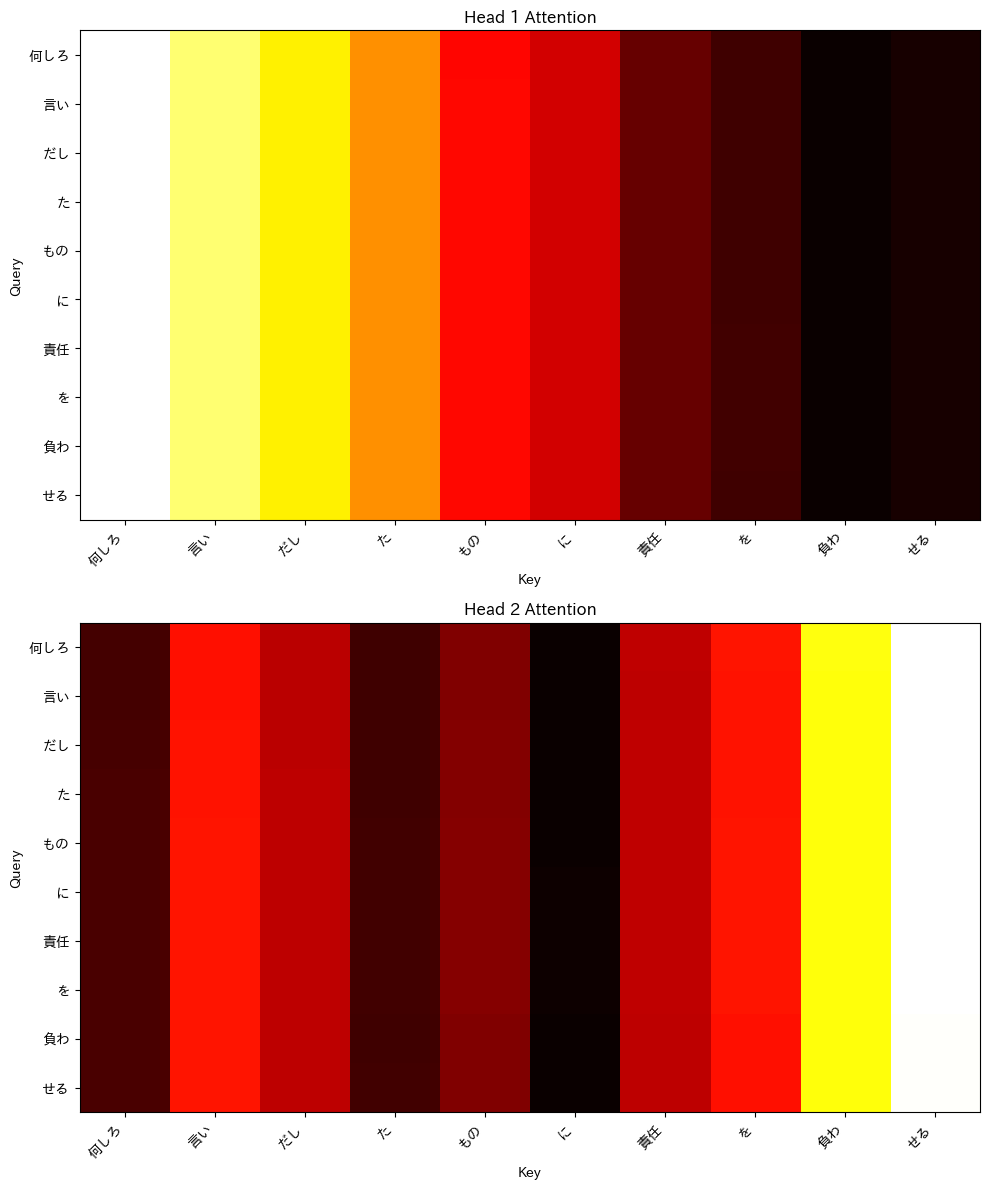

In [26]:
# @title 未学習のモデルで視覚化
baby_model = GPT(vocab_size, context_size, d_model, n_head, n_block)
baby_model.to(device)
baby_model.eval()
inputs = evaluate.input_tokens(parsed_corpus)
_, w = baby_model(inputs)
visualize_attention_weights(w[0].cpu(), parsed_corpus) # バッチの次元は除外

In [27]:
w.shape

torch.Size([1, 2, 10, 10])

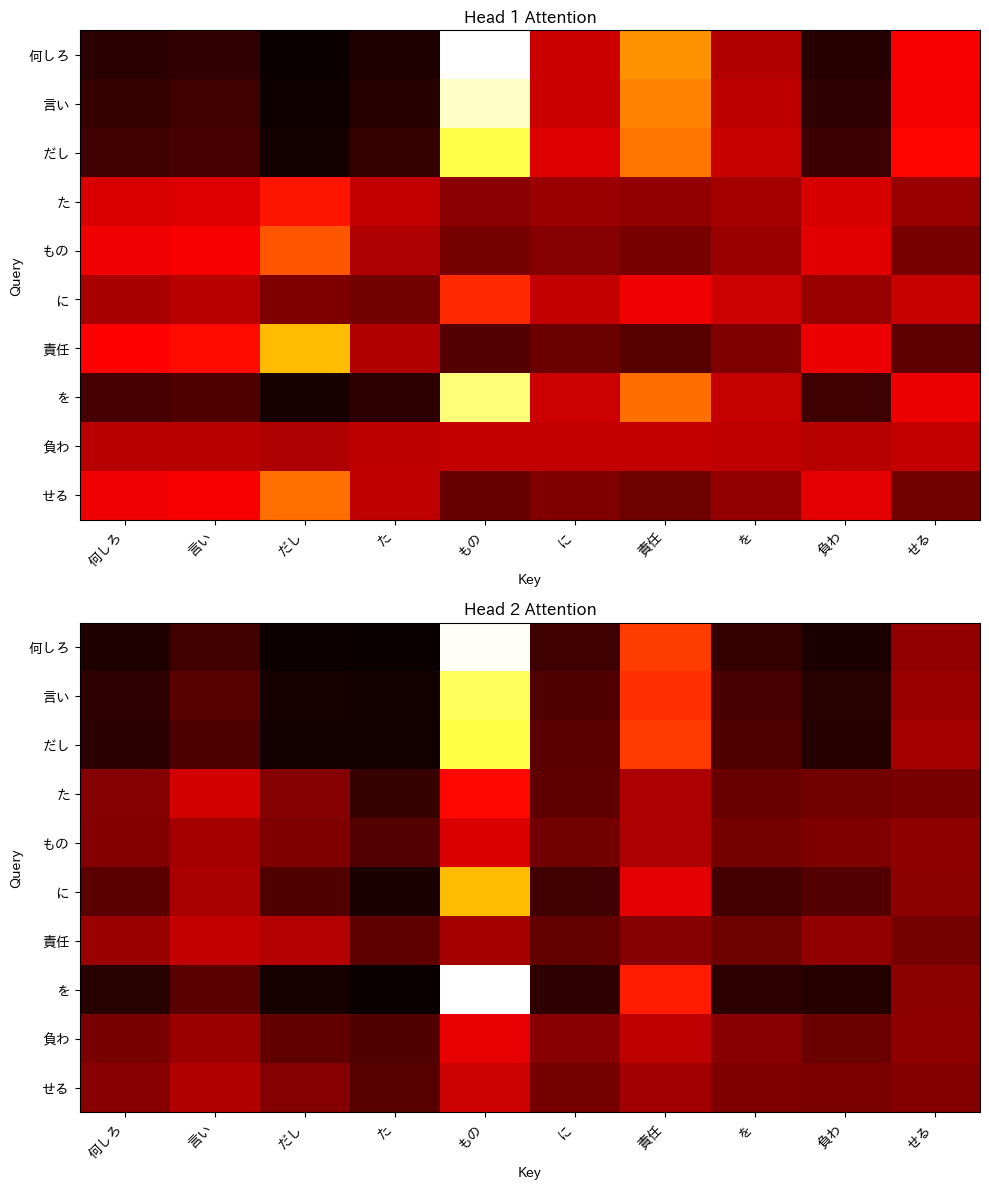

In [28]:
# @title 学習中のモデルで視覚化
inputs = evaluate.input_tokens(parsed_corpus)
model.eval()
inputs = inputs.to(device)
model.to(device)
_, w = model(inputs)
# outputs, w = model(inputs, mask)
visualize_attention_weights(w[0].cpu(), parsed_corpus) # バッチの次元は除外